# Set-valued prediction based on utility maximization 

In [239]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from itertools import chain, combinations

<div align="justify">


In line with classical statistics, but unlike decision theory and machine learning, the setting of conformal prediction does not involve any notion of loss function. In this regard, it differs from methods for set-valued prediction based on utility maximization (or loss minimization), which are primarily used for multi-class classification problems. Similar to conformal prediction, such methods also return a set of classes when the classifier is too uncertain with respect to the class label to predict, but the interpretation of this set is different. Instead of returning a set that contains the true class label with high probability, sets that maximize a set-based utility score are sought. Besides, being based on the conditional distribution $ \prob(y\,|\,\vec{x}_q) $ of the outcome $ y $ given a query $ \vec{x}_q $, most of these methods capture *conditional* uncertainty. 

Let $u(y,\sety)$ be a set-based utility score, where $y$ denotes the ground truth outcome and $\sety$ the predicted set. Then, adopting a decision-theoretic perspective, the Bayes-optimal solution $\sety^{*}_u$ is found by maximizing the following objective:

$$
\sety^{*}_u(\vec{x}_q) = \argmax_{\sety \in 2^{\mathcal{Y}}\setminus \{\emptyset\}} \evalue_{p(y\,|\,\vec{x}_q)} \big( u(y,\sety) \big) = \argmax_{\sety \in 2^{\mathcal{Y}}\setminus \{\emptyset\}} \sum_{y \in \mathcal{Y}} u(y,\sety) \, p(y\,|\,\vec{x}_q) \,.
$$(bayesoptimal)

Solving {eq}`bayesoptimal` as a brute-force search requires checking all subsets of $\mathcal{Y}$, resulting in an exponential time complexity.
Assuming we have four classes as in the figure below and we are interested in predicting the set of the new point $\vec{x}_q$.

</div>

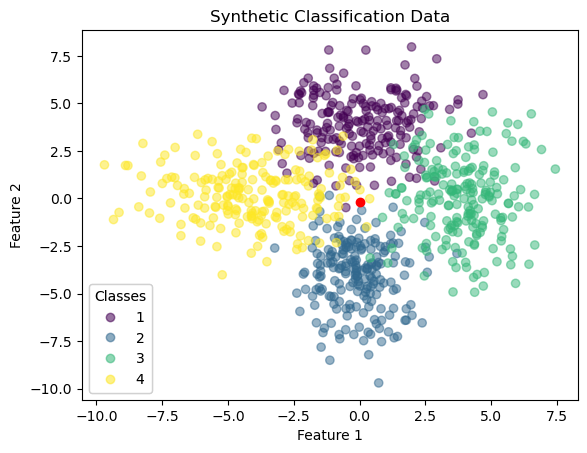

In [240]:
def powerset_without_empty_set(iterable):
    "powerset([1,2,3]) → () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1,len(s)+1)) # we start with 1 to not have the empty set contained

def plot_synthetic_data(ax,X,y, new_point, title):
    ax.set_title(title)

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, alpha=.5)
    ax.scatter(*new_point, c="r")

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
    ax.add_artist(legend1)

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")


n_samples = 200
n_classes = 4
classes = list(range(1,n_classes+1))
random_state = 41

# parameters for toy data
means = [(0,4),(0,-4),(4,0),(-4,0)]
covs = [np.eye(2)*2.5,np.diag([1.5,2.8]), np.diag([1.5,4.5]), np.diag([3.8,2])]

np.random.seed(random_state)

X = np.vstack([
    np.random.multivariate_normal(mean,cov,n_samples) 
    for mean,cov in zip(means,covs)
])
y = np.hstack([np.full(n_samples,i) for i in classes])

x_q = np.array([0, -0.2])

fig, ax = plt.subplots()

plot_synthetic_data(ax,X,y,x_q,"Synthetic Classification Data")

plt.show()

We firstly must train an classification model on the data, here we choose the [Gaussian Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html), through which we construct the conditional probability $p(y\,|\,\vec{x}_q)$.

In [241]:
gaussian_model = GaussianNB()
gaussian_model.fit(X,y)
conditional_probability_query_point = gaussian_model.predict_proba(x_q.reshape(1,-1)).flatten()
for i in classes:
    print(f"P(y = {i} | x_q) = {round(conditional_probability_query_point[i-1], 3)}")

P(y = 1 | x_q) = 0.094
P(y = 2 | x_q) = 0.43
P(y = 3 | x_q) = 0.045
P(y = 4 | x_q) = 0.43


<div align="justify">

To predict the set $\sety$ we must iterate over all possible $\sety \in 2^{\mathcal{Y}}\setminus \{\emptyset\}$ to construct the prediction interval. 
We choose as utility score 

$$

u(y,\sety) = \left \{ 
\begin{array}{cl}
0 &\quad \mbox{if $y \notin \sety$} \ \\
\frac{2}{ (1 + |\sety| }&\quad \mbox{if $y \in \sety$} 
\end{array} \, ,
\right.

$$

which represents the well-known notion of $F_1$-measure ({cite:p}`delc_ln09`).
Intuitively it gives a reward of 0, if the true label is not contained in the prediction set and penalizes bigger sets over smaller ons.
Especially for $|\sety| = 1$ the utility score is maximized, i.e. $u(y,\sety) = 1$ .
A more general formulation of $u(y,\sety)$ will be later on introduced.


</div>


In [242]:
def utility_function(contained_function,y,set_prediction):
    if y in set_prediction:
        return contained_function(len(set_prediction))
    else:
        return 0
    

def build_prediction_set(utility_score, classes, conditional_probability):
    predictions_sets = powerset_without_empty_set(classes)
    
    max_value,set_prediction = -1, None
    # iterate over all possible prediction_sets
    for predictions_set in predictions_sets: 
        # build the averaged score the prediction set achieves given the conditional probability
        averaged_utility = np.sum(np.array([utility_score(y,predictions_set) for y in classes]) * conditional_probability)
        # find the max_value and set_prediction
        if max_value < averaged_utility:
            max_value = averaged_utility
            set_prediction = np.array(predictions_set)
            
    return set_prediction


def f1_utility_function(y,set_prediction):
    def precision(score):
        return 2/(1 + score)
    return utility_function(precision,y,set_prediction)


Applying this utility function to teh query point $\vec{x}_q$ results in the following prediction set:


In [243]:
print("Prediction set for x_q with F1-measure: ", build_prediction_set(f1_utility_function, classes, conditional_probability_query_point))

Prediction set for x_q with F1-measure:  [2 4]


<div align="justify">

However, for many utility scores, the Bayes-optimal prediction can be found more efficiently. Various methods in this direction have been proposed under different names and qualifications of predictions, such as "indeterminate" {cite:t}`zaffalon2002`, "credal" {cite:t}`cora_lr08`, "non-deterministic" {cite:t}`delc_ln09`, and "cautious" {cite:t}`Yang2017b`. Although the methods typically differ in the exact shape of the utility function $u: \mathcal{Y} \times 2^{\mathcal{Y}}\setminus \{\emptyset\} \longrightarrow [0,1]$, most functions are specific members of the following family:

$$

u(y,\sety) = \left \{ 
\begin{array}{cl}
0 &\quad \mbox{if $y \notin \sety$} \ \\
g(|\sety|)&\quad \mbox{if $y \in \sety$} 
\end{array} \, ,
\right.

$$(ufamily)


where $|\sety|$ denotes the cardinality of the predicted set $\sety$. 
This family is characterized  by a sequence $(g(1), \ldots,g(K)) \in [0,1]^K$ with $K$ the number of classes. Ideally, $g$ should obey the following properties: 

1. $g(1) = 1$, i.e., the utility $u(y,\sety)$ should be maximal when the classifier returns the true class label as a singleton set.
2. $g(s)$ should be non-increasing, i.e., the utility $u(y,\sety)$ should be higher if the true class is contained in a smaller set of predicted classes.
3. $g(s) \geq 1/s$, i.e., the utility $u(y,\sety)$ of predicting a set containing the true and $s-1$ additional classes should not be lower than the expected utility of randomly guessing one of these $s$ classes. This requirement formalizes the idea of risk-aversion: in the face of uncertainty, abstaining should be preferred to random guessing {cite:p}`Zaffalon2012EvaluatingCC`. 

Many existing set-based utility scores are recovered as special cases of {eq}`ufamily`, including the three classical measures from information retrieval discussed by {cite:t}`delc_ln09`: precision with $g_P(s) = 1/s$, recall with $g_R(s)=1$, and the F$_{1}$-measure with $g_{F1}(s) = 2/(1+s)$.  Applying recall or precision to the above example yields:

</div>

In [244]:
def precision_utility_function(y,set_prediction):
    def precision(score):
        return 1/score
    return utility_function(precision,y,set_prediction)

def recall_utility_function(y,set_prediction):
    def precision(score):
        return 1
    return utility_function(precision,y,set_prediction)

print("Prediction set for x_q with Precision-measure: ", build_prediction_set(precision_utility_function, classes, conditional_probability_query_point))
print("Prediction set for x_q with Recall-measure: ", build_prediction_set(recall_utility_function, classes, conditional_probability_query_point))

Prediction set for x_q with Precision-measure:  [2]
Prediction set for x_q with Recall-measure:  [1 2 3 4]


<div align="justify">

Other utility functions with specific choices for $g$ are studied in the literature on credal classification {cite:p}`Corani2008NCC,Corani2009LNCC,Zaffalon2012EvaluatingCC,Yang2017b,mpub385`, such as

$$

g_{\delta,\gamma}(s) := \frac{\delta}{s} - \frac{\gamma}{s^2} \,, \quad g_{\exp}(s) := 1- \exp{\left(-\frac{\delta}{s}\right)},   \quad g_{log}(s) := \log \left(1 + \frac{1}{s} \right) \,.

$$
Especially $g_{\delta,\gamma}(s)$ is commonly used in this community, where $\delta$ and $\gamma$ can only take certain values to guarantee that the utility is in the interval $[0,1]$. Precision (here called discounted accuracy) corresponds to the case $(\delta,\gamma)=(1,0)$. However, typical choices for $(\delta,\gamma$) are $(1.6,0.6)$ and $(2.2,1.2)$ {cite:p}`mpub385`, implementing the idea of risk aversion. The measure $g_{\exp}(s)$ is an exponentiated version of precision, where the parameter $\delta$ also defines the degree of risk aversion. 

</div>


<div align="justify">


Another example appears in the literature on binary or multi-class classification with reject option {cite:p}`herb_cw06,linu_cw18,Ramaswamy2015CAMCRO`. Here, the prediction can only be a singleton or the full set $\mathcal{Y}$ containing $K$ classes. The first case typically gets a reward of one (if the predicted class is correct), while the second case should receive a lower reward, e.g. $1-\alpha$.  The latter corresponds to abstaining, i.e., not predicting any class label, and the (user-defined) parameter $\alpha$ specifies a penalty for doing so, with the requirement $0< \alpha < 1-1/K$ to be risk-averse. 

Set-valued predictions are also considered in hierarchical multi-class classification, mostly in the form of internal nodes of the hierarchy  {cite:p}`Freitas_atutorial,Rangwala2017,Yang2017`. Compared to the ''flat'' multi-class case, the prediction space is thus restricted, because only sets of classes that correspond to nodes of the hierarchy can be returned as a prediction. Some of the above utility scores also appear here. For example, \citet{Yang2017} evaluate various members of the $u_{\delta,\gamma}$ family in a framework where hierarchies are considered for computational reasons, while {cite:t}`Oh2017TopKHC` optimizes recall by fixing $|\sety|$ as a user-defined parameter. 
Popular in hierarchical classification is the tree-distance loss, which could also be interpreted as a way of evaluating set-valued predictions {cite:p}`Bi2015`. 
This loss is not a member of the family ({eq}`ufamily`), however. 
Besides, it appears to be a less interesting loss function from the perspective of abstention in cases of uncertainty, since by minimizing the tree distance loss, the classifier will almost never predict leaf nodes of the hierarchy. 
Instead, it will often predict nodes close to the root of the hierarchy, which correspond to sets with many elements\,---\,a behavior that is unfavored if one wants to abstain only in cases of sufficient uncertainty. 

Quite obviously, methods that maximize set-based utility scores are closely connected to the quantification of uncertainty, since the decision about a suitable set of predictions is necessarily derived from information of that kind. The overwhelming majority of the above-mentioned methods depart from conditional class probabilities $p(y \given \vec{x}_q)$ that are estimated in a classical frequentist way, so that uncertainties in decisions are of aleatoric nature. 
Exceptions include {cite:p}`Yang2017` and {cite:p}`mpub385`, who further explore ideas from imprecise probability theory and reliable classification to generate label sets that capture both aleatoric and epistemic uncertainty.   

</div>
